In [51]:
%matplotlib inline
import cv2 #　opencvのインポート
import matplotlib
import matplotlib.pyplot as plt # matplotlib(描画用)
import matplotlib.patches as patches
import numpy as np
import random
import math

print('opencv version: ' + cv2.__version__)
print('matplotlib version: ' + matplotlib.__version__)
print('numpy version: ' + np.__version__)

opencv version: 4.1.2
matplotlib version: 3.2.1
numpy version: 1.18.5


In [52]:
# このセルはGoogle Colaboratory使用時のみ必要
from google.colab import files
f = files.upload() # ファイルアップロード

Saving 161.png to 161 (1).png
Saving bread.png to bread (1).png
Saving bumpy.png to bumpy (1).png
Saving col-br.png to col-br (1).png
Saving D1.png to D1 (1).png
Saving D3.png to D3 (1).png
Saving D18.png to D18 (1).png
Saving D20.png to D20 (1).png
Saving text3.png to text3 (1).png
Saving wood.png to wood (1).png


> 6.3. Texture synthesis: Implement the non-parametric texture synthesis algorithm of Algorithm 6.4.

以下, 自作したノンパラメトリックのテクスチャ合成の実装を示す.  
なお実装に当たってこのアルゴリズムを考案した人のホームページを参考にした.  
https://people.eecs.berkeley.edu/~efros/research/EfrosLeung.html  
https://people.eecs.berkeley.edu/~efros/research/NPS/alg.html (アルゴリズムの疑似コード)


In [93]:
def SetRandomBlock(sample_img, syn_img, ini_block_size=3): # block size should be odd number
  # サンプル画像から初期ブロック中心をランダムに選択
  block_size_half = ini_block_size // 2
  sample_h, sample_w, _ = sample_img.shape
  rand_x = random.randint(block_size_half, sample_w - block_size_half - 1)
  rand_y = random.randint(block_size_half, sample_h - block_size_half - 1)

  # 合成画像中央に初期ブロックを配置する
  syn_h, syn_w, _ = syn_img.shape
  syn_img_center_x = syn_w // 2
  syn_img_center_y = syn_h // 2
  for i in range(-block_size_half, block_size_half+1):
    for j in range(-block_size_half, block_size_half+1):
      syn_img[syn_img_center_y + i, syn_img_center_x + j] = [*sample_img[rand_y + i, rand_x + j], 1.]

def IsPixelSynthesized(pixel):
  return True if pixel[3] > 0.5 else False

def GetUnfilledNeighborsIndices(syn_img):
  unfilled_indices = []
  syn_h, syn_w, _ = syn_img.shape

  for i in range(syn_h):
    for j in range(syn_w):
      # 自身が合成済み画素の場合はスキップ
      if IsPixelSynthesized(syn_img[i, j]):
        continue
      
      # 周囲8画素の中に合成済み画素があれば未合成近傍として格納
      for ii in [-1, 0, 1]:
        for jj in [-1, 0, 1]:
          if ii == 0 and jj == 0:
            continue
          elif i+ii < 0 or i+ii >= syn_h or j+jj < 0 or j+jj >= syn_w:
            continue
          
          if IsPixelSynthesized(syn_img[i+ii, j+jj]):
            unfilled_indices.append((i, j))
            break
        else:
          continue
        break

  return unfilled_indices

def GetNeighborhoodWindow(syn_img, index, win_h, win_w):
  window = np.zeros((win_h, win_w, 4))
  y, x = index
  win_h_half = win_h // 2
  win_w_half = win_w // 2
  for i in range(win_h):
    rel_y = y+(i-win_h_half)
    for j in range(win_w):
      rel_x = x+(j-win_w_half)
      
      # 合成画像の範囲外となる窓画素には未合成画素の情報を入れておく
      if rel_y < 0 or rel_y >= syn_img.shape[0] or rel_x < 0 or rel_x >= syn_img.shape[1]:
        window[i, j] = [0., 0., 0., 0.]
        continue

      window[i, j] = syn_img[rel_y, rel_x]
  
  return window

def GetValidMask(template, h, w):
  valid_mask = np.empty((h, w, 1), dtype=int)
  valid_mask[template[:, :, 3] < 0.5] = 0
  valid_mask[template[:, :, 3] > 0.5] = 1
  return valid_mask

def GetGaussianMask(h, w):
  gaussian_mask = np.empty((h, w, 1), dtype=float)
  h_half = h // 2
  w_half = w // 2
  sigma = max(h, w) / 6.4

  for i in range(h):
    for j in range(w):
      tmp = abs(i-h_half) + abs(j-w_half)
      if tmp == 0:
         gaussian_mask[i, j] = 1
      else:
        gaussian_mask[i, j] = 1 / tmp

  return gaussian_mask

# 定数値 based on https://people.eecs.berkeley.edu/~efros/research/NPS/alg.html
ERR_THRESHOLD = 0.1

# サンプル画像から近傍窓（テンプレート）と類似している箇所をマッチング処理で探索
def FindMatches(template, sample_img):
  h, w, _ = sample_img.shape
  ht, wt, _ = template.shape
  ht_half = ht // 2
  wt_half = wt // 2

  valid_mask = GetValidMask(template, ht, wt)
  template_img = template[:, :, :3] # 4要素目（合成済み確認の要素）の削除

  # SSDを計算
  score = np.empty((h-ht, w-wt))
  for y in range(h - ht):
    for x in range(w - wt):
      diff = valid_mask * (((sample_img[y:y+ht, x:x+wt] - template_img)**2))
      score[y, x] = diff.sum()

  # SSD最小値
  score_min = score.min()

  # (1+threshold)*min(ssd)以下のSSDを持つ画素位置を取得
  match_indices = list(zip(*np.where(score <= (1+ERR_THRESHOLD)*score_min)))
  return match_indices

def RandomPick(matches):
  return random.choice(matches)

In [94]:
# テクスチャをもとに画像の未合成領域を合成する
def GrowImage(sample_img, syn_img, window_size):
  win_h, win_w = window_size
  win_h_half = win_h // 2
  win_w_half = win_w // 2

  unfilled_indices =  GetUnfilledNeighborsIndices(syn_img)
  while unfilled_indices:
    for index in unfilled_indices:
      template = GetNeighborhoodWindow(syn_img, index, win_h, win_w)
      best_matches = FindMatches(template, sample_img)
      best_match = RandomPick(best_matches)
      syn_img[index] = [*sample_img[best_match[0]+win_h_half, best_match[1]+win_w_half], 1.]
    
    unfilled_indices =  GetUnfilledNeighborsIndices(syn_img)

# テクスチャ合成の実行
def ExcecuteSynthesis(texture_path, window_size, syn_size):
  # 元となるテクスチャ画像
  img = cv2.imread(texture_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img / 255. # from 0 to 1

  # 合成画像
  syn_img = np.zeros((syn_size, syn_size, 4), dtype=float) # α要素を合成後かどうかの判定に使う（合成前:0, 合成後:1）
  SetRandomBlock(img, syn_img)

  # 合成
  GrowImage(img, syn_img, window_size)
  return syn_img

実際に1枚のテクスチャ画像に対して合成画像を生成するテスト用関数が以下である.

複数のウィンドウサイズに対して処理を行い, 合成画像を表示している.

In [106]:
# オリジナル画像を表示
def ShowOriginal(file_path):
  img = cv2.imread(file_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  plt.title('Original Image'), plt.xticks([]), plt.yticks([])
  plt.imshow(img)

# テクスチャ合成画像を生成（テスト用関数）
def TestSynthesis(file_path, window_sizes, syn_size, show_elapsed=False):
  for i, size in enumerate(window_sizes):
    if show_elapsed:
      start = time.time()
    
    # 合成
    synthesized = ExcecuteSynthesis(file_path, size, syn_size)

    if show_elapsed:
      elapsed_time = time.time() - start
      print ('size: ' + str(size) + ' ' + "elapsed_time:{0}".format(elapsed_time) + "[sec]")

    # 合成された画像を表示
    plt.subplot(1, len(window_sizes), i+1),plt.imshow(synthesized)

> (a) the effect of window size on the synthesized texture;  
(b) the effect of window shape on the synthesized texture; and  
(c) the effect of the matching criterion on the synthesized texture (i.e., using
a weighted sum of squares instead of a sum of squares, etc.).

これらを順番に試していく.  
以降, 合成画像のサイズは70×70とした.  

まずは (a)ウィンドウサイズ変更の影響 を試すために, いくつかの正方形のウィンドウサイズで実行した結果を次に示す.  
左から順番に(5, 5), (11, 11), (17, 17), (23, 23)のウィンドウサイズで実行した結果であるが, (11, 11)のときが一番よく見える.  
(5, 5)では近場しか見ることが出来ないことから, 元の画像パターンの形状の特徴が崩れて出力されてしまっていることが分かる.  
(17, 17), (23, 23)では広い区間を見過ぎて最小SSD（Sum of Squared Differences）に近い値が増えてしまい, あまり似ていない画素もマッチングしてしまうからか, ノイズのような画素が多く見られるようになってしまった.

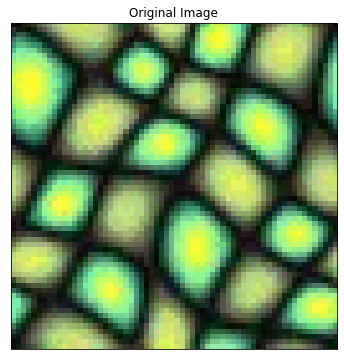

In [108]:
# 合成元のテクスチャ画像
matplotlib.pyplot.rcParams['figure.figsize'] = (6.0, 6.0)
ShowOriginal('161.png')

size: (5, 5) elapsed_time:142.27280807495117[sec]
size: (11, 11) elapsed_time:150.67098689079285[sec]
size: (17, 17) elapsed_time:156.83335399627686[sec]
size: (23, 23) elapsed_time:161.2946538925171[sec]


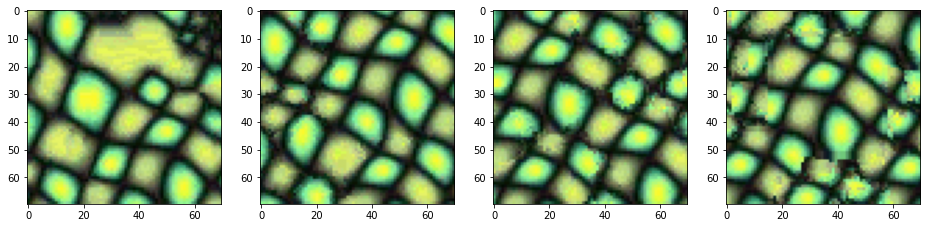

In [112]:
test_window_sizes = [(5, 5), (11, 11), (17, 17), (23, 23)]
matplotlib.pyplot.rcParams['figure.figsize'] = (16.0, 16.0)
TestSynthesis('161.png', test_window_sizes, 70, True)

次に (b)ウィンドウの形の変更による影響 を試すためにいくつかの正方形でないウィンドウサイズで実行した結果を示す.  
ウィンドウサイズが少し大きいため(a)の結果と同様にノイズが発生しているが, (5, 23)の方では横方向に, (23, 5)の方では縦方向に亀裂が生じるようなずれやノイズが発生している箇所が見受けられる.  
これは, 横長のウィンドウでは縦方向, 縦長のウィンドウでは横方向の可視範囲が狭いことで, もう片方の方向よりもSSD計算時に扱える情報が少なくなってしまうためだと考えられる.

size: (5, 23) elapsed_time:123.62713599205017[sec]
size: (23, 5) elapsed_time:121.88055920600891[sec]


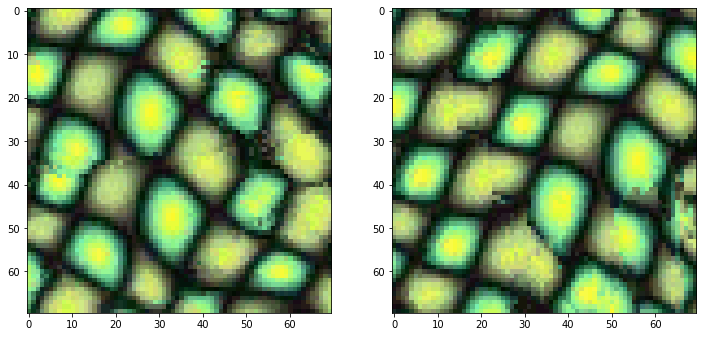

In [113]:
test_window_sizes = [(5, 23), (23, 5)]
matplotlib.pyplot.rcParams['figure.figsize'] = (12.0, 12.0)
TestSynthesis('161.png', test_window_sizes, 70, True)

最後に (c)マッチング基準の変更による影響 を試すために, マッチングを通常のSSDではなく中央から遠ざかるほど値が小さいマスクをかけたSSDで実行した結果を次に示す.  
(a)の結果と比べてみると, 出力のパターンの形状は似ているものの, ノイズのような画素が減っていることが分かる.  
これは通常のSSDでは中央画素から遠い値でも同じ重みがかかっていたのに対して, (c)では中央画素（注目している非合成画素）に近いほどより重みがかかることで, 中央画素付近が似ていても遠くの位置が似ていない場合のマッチングでSSDが大きくなり, より最小SSDとの差が開いたからだと考えられる.

In [114]:
# サンプル画像から近傍窓（テンプレート）と類似している箇所をマッチング処理で探索
def FindMatches(template, sample_img):
  h, w, _ = sample_img.shape
  ht, wt, _ = template.shape
  ht_half = ht // 2
  wt_half = wt // 2

  valid_mask = GetValidMask(template, ht, wt)
  gaussian_mask = GetGaussianMask(ht, wt)
  tot_weight = (valid_mask * gaussian_mask).sum()
  template_img = template[:, :, :3] # 4要素目（合成済み確認の要素）の削除

  # SSDを計算
  score = np.empty((h-ht, w-wt))
  for y in range(h - ht):
    for x in range(w - wt):
      #diff = valid_mask * (((sample_img[y:y+ht, x:x+wt] - template_img)**2))
      diff = (valid_mask * gaussian_mask) * ((sample_img[y:y+ht, x:x+wt] - template_img)**2) # ガウシアンを用いる
      score[y, x] = diff.sum() / tot_weight

  # SSD最小値
  score_min = score.min()

  # (1+threshold)*min(ssd)以下のSSDを持つ画素位置を取得
  match_indices = list(zip(*np.where(score <= (1+ERR_THRESHOLD)*score_min)))
  return match_indices


size: (5, 5) elapsed_time:170.6080675125122[sec]
size: (11, 11) elapsed_time:177.2873785495758[sec]
size: (17, 17) elapsed_time:186.95143508911133[sec]
size: (23, 23) elapsed_time:191.31198263168335[sec]


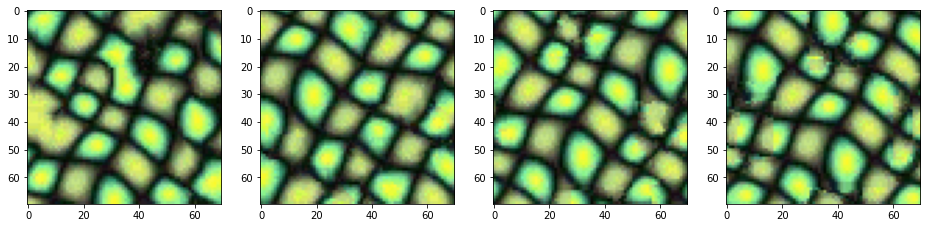

In [115]:
test_window_sizes = [(5, 5), (11, 11), (17, 17), (23, 23)]
matplotlib.pyplot.rcParams['figure.figsize'] = (16.0, 16.0)
TestSynthesis('161.png', test_window_sizes, 70, True)

(c)の条件で他の画像でも試してみた.

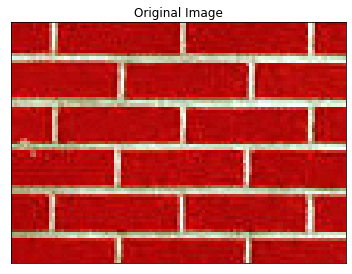

In [118]:
# 合成元のテクスチャ画像
matplotlib.pyplot.rcParams['figure.figsize'] = (6.0, 6.0)
ShowOriginal('col-br.png')

size: (5, 5) elapsed_time:363.14450454711914[sec]
size: (11, 11) elapsed_time:383.116708278656[sec]
size: (17, 17) elapsed_time:454.9135775566101[sec]
size: (23, 23) elapsed_time:506.8179109096527[sec]


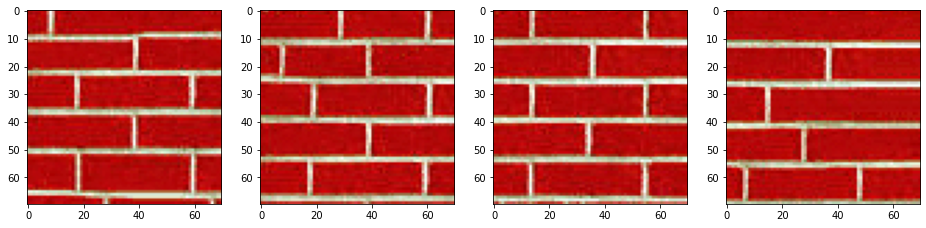

In [119]:
test_window_sizes = [(5, 5), (11, 11), (17, 17), (23, 23)]
matplotlib.pyplot.rcParams['figure.figsize'] = (16.0, 16.0)
TestSynthesis('col-br.png', test_window_sizes, 70, True)

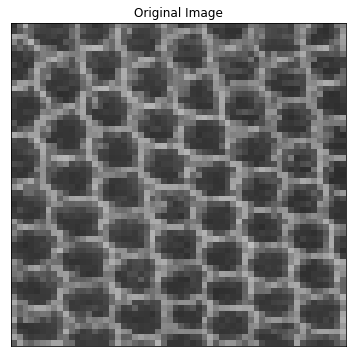

In [121]:
# 合成元のテクスチャ画像
matplotlib.pyplot.rcParams['figure.figsize'] = (6.0, 6.0)
ShowOriginal('D3.png')

size: (5, 5) elapsed_time:132.79106903076172[sec]
size: (11, 11) elapsed_time:136.8300654888153[sec]
size: (17, 17) elapsed_time:136.20597386360168[sec]
size: (23, 23) elapsed_time:133.78040289878845[sec]


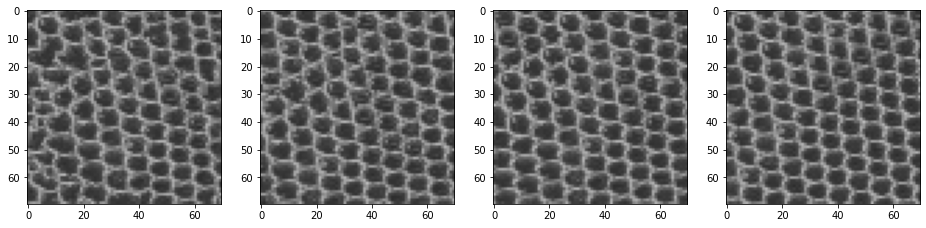

In [120]:
test_window_sizes = [(5, 5), (11, 11), (17, 17), (23, 23)]
matplotlib.pyplot.rcParams['figure.figsize'] = (16.0, 16.0)
TestSynthesis('D3.png', test_window_sizes, 70, True)

以上.